In [1]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd

In [2]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.feature_extraction import image
from PIL import Image, ImageEnhance

In [3]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage.morphology import label
from skimage.measure import regionprops
from skimage import data, util

In [4]:
import matplotlib.patches as mpatches
from random import random

In [5]:
from scipy import ndimage
from scipy.ndimage import find_objects

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC

In [7]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.12026201002202846


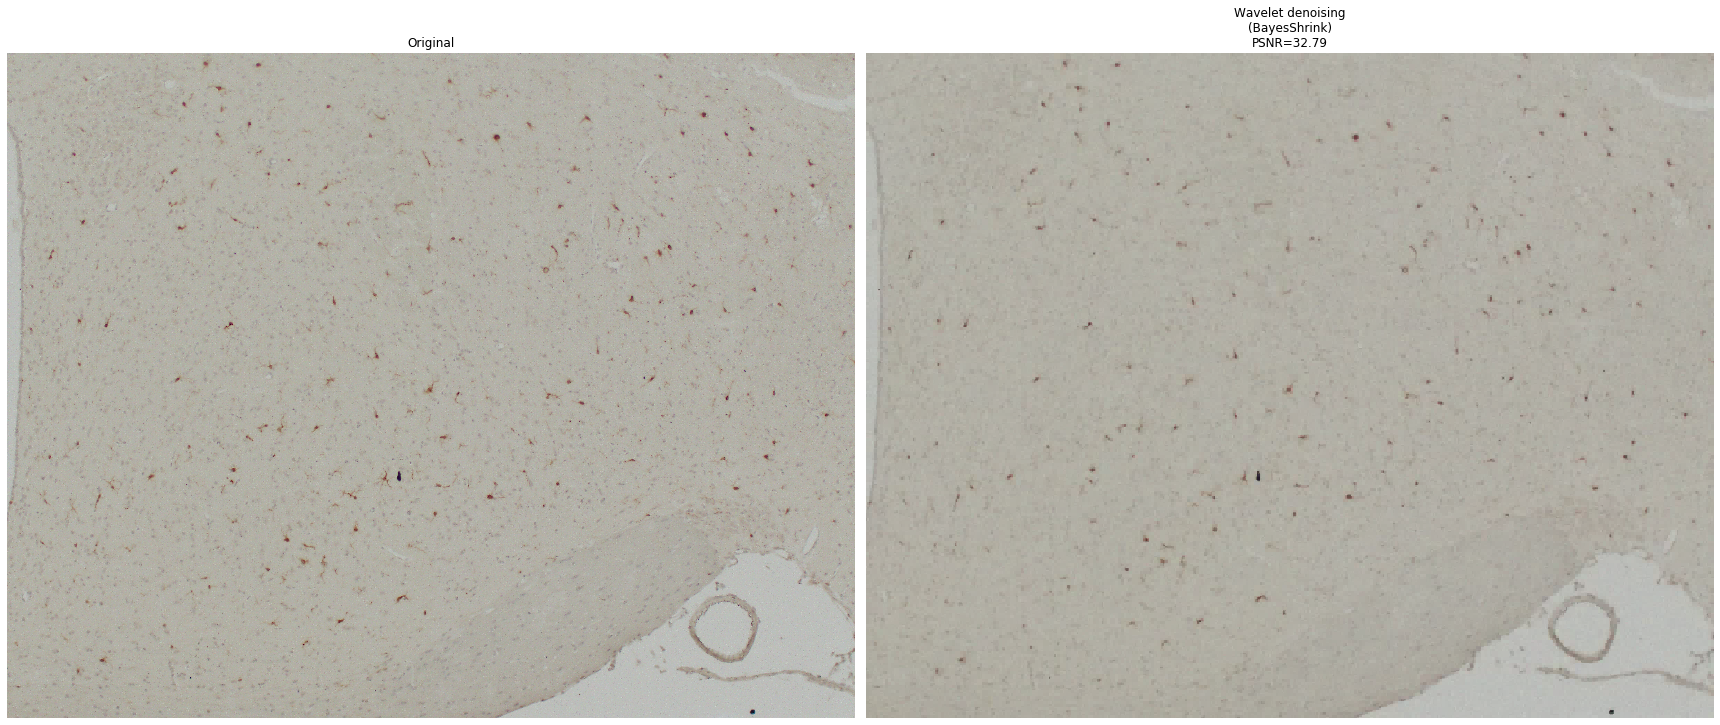

In [8]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, seed=1, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

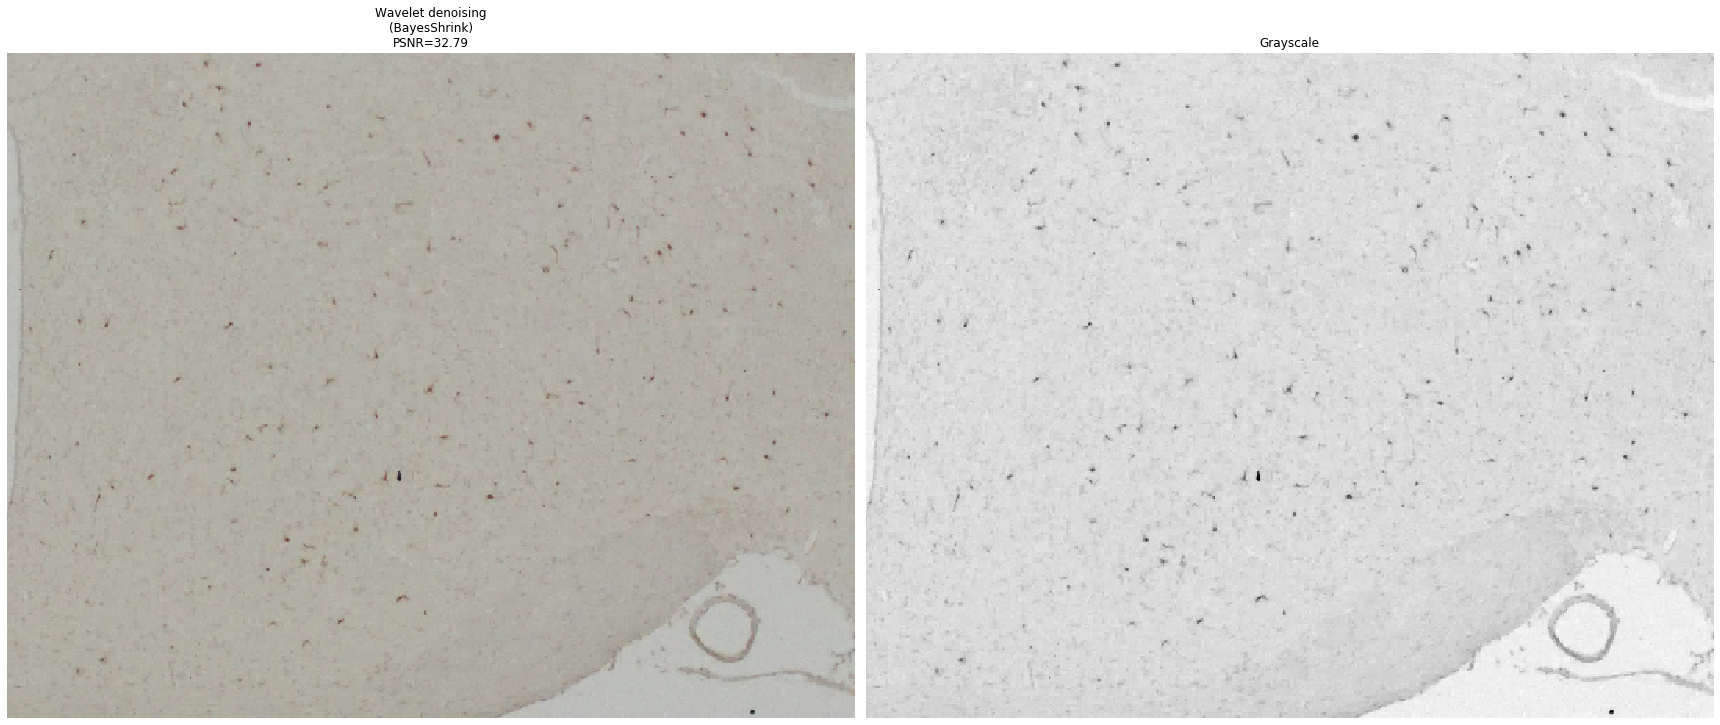

In [9]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

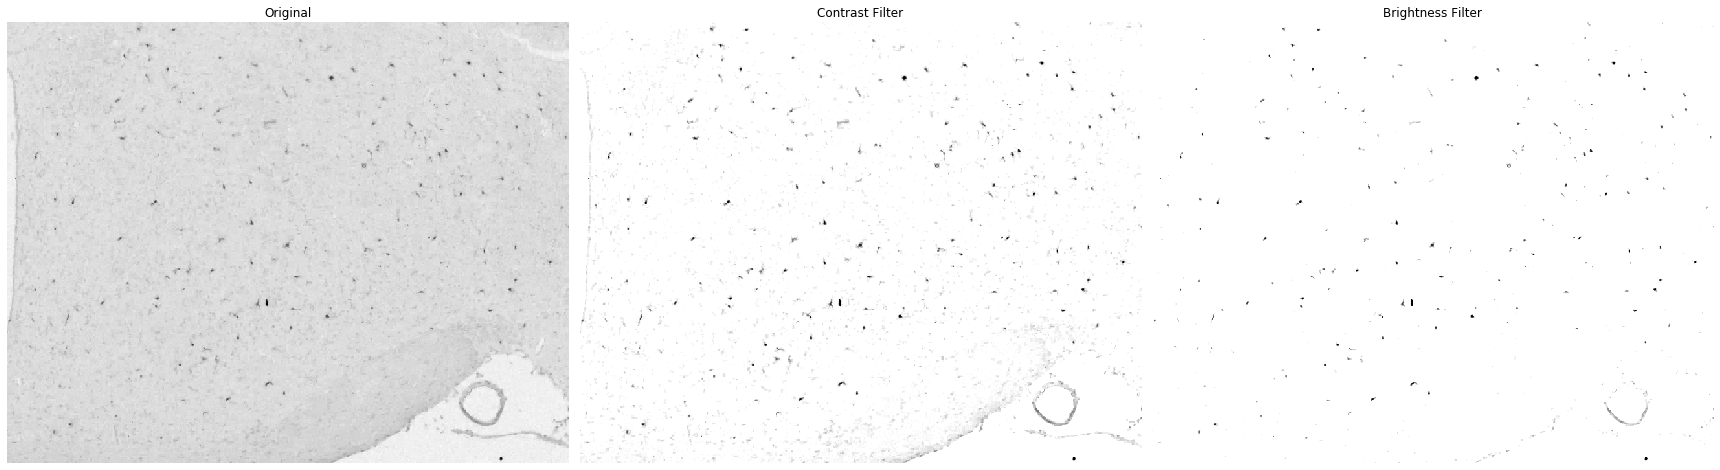

In [10]:
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [11]:
bright_bayes = np.array(bright_bayes_pil)

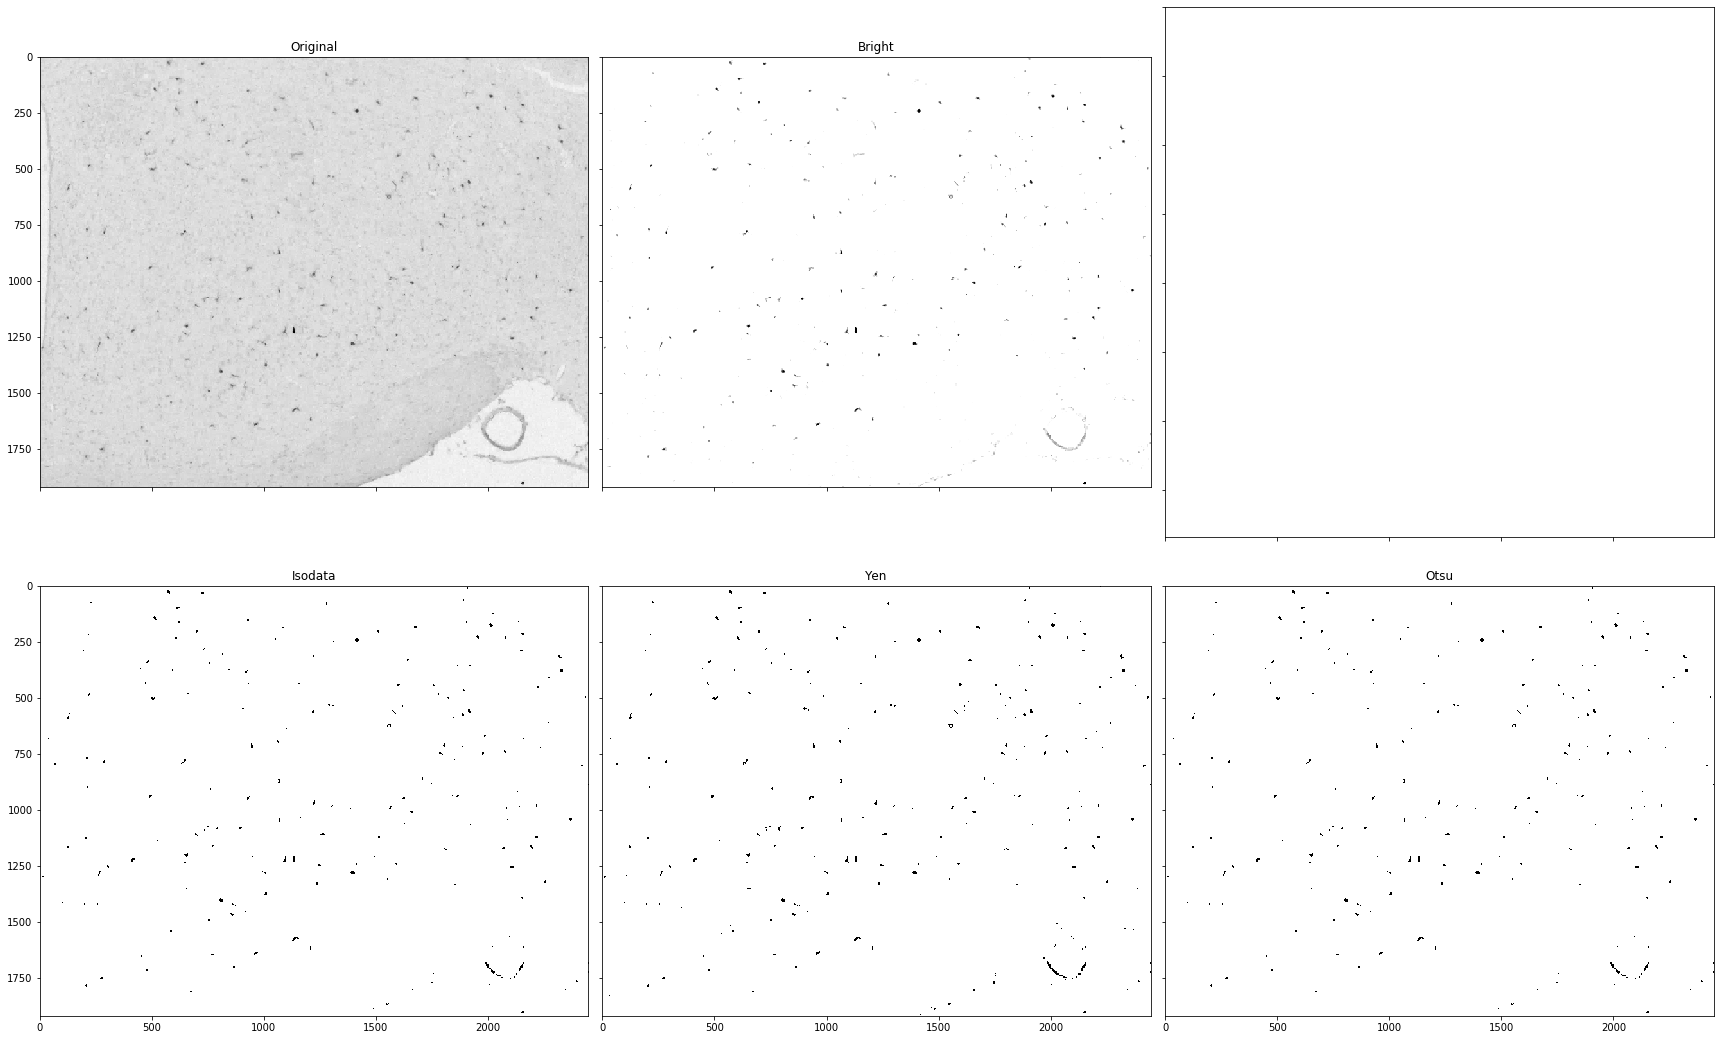

In [12]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [13]:
#define new colormap
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

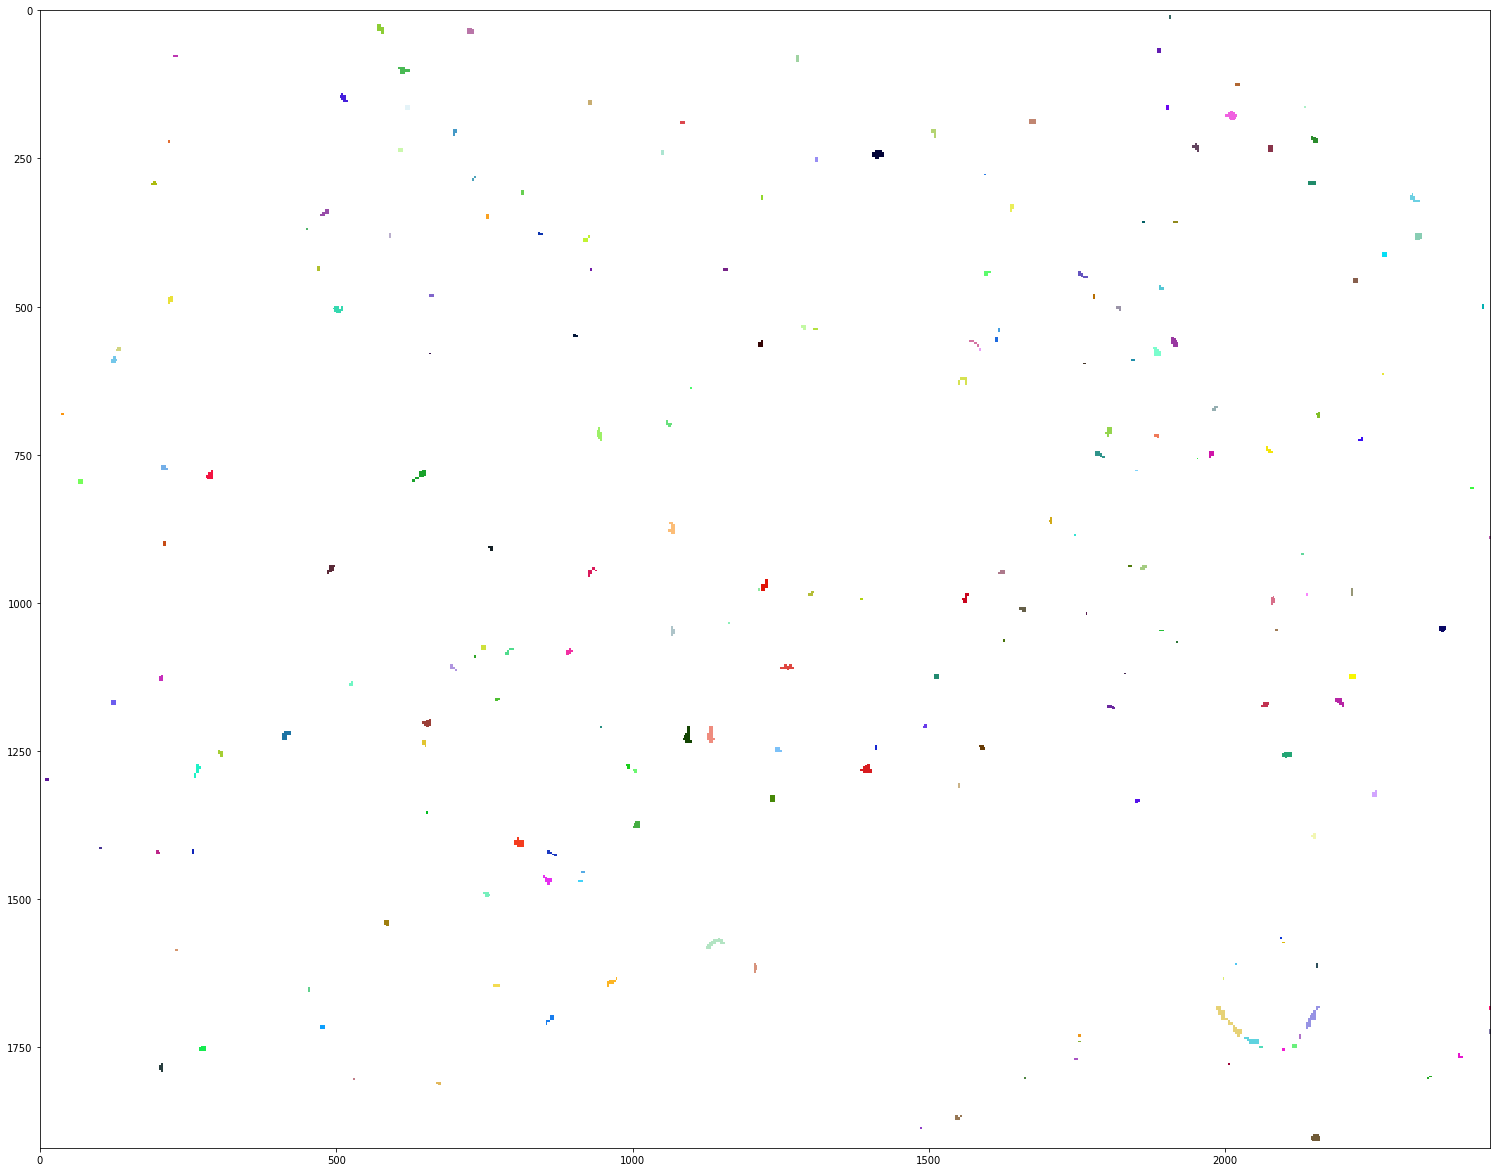

In [14]:
# label image regions
label_image = label(isodata,connectivity=2, background=1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(26, 26))
ax.imshow(label_image, cmap = new_map)

plt.show()

In [15]:
patches = ndimage.find_objects(label_image)
len(patches)

208

In [16]:
patches_sample = [patches[0], patches[1], patches[2]]
patches_sample

[(slice(8, 16, None), slice(1904, 1908, None)),
 (slice(24, 40, None), slice(568, 580, None)),
 (slice(30, 40, None), slice(720, 732, None))]

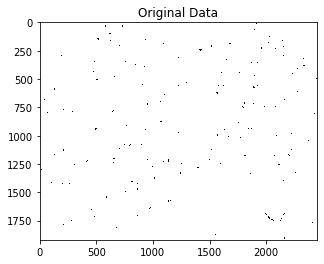

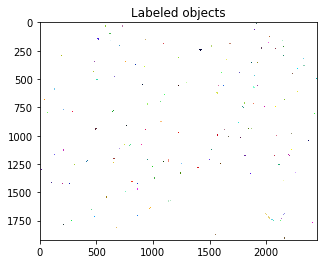

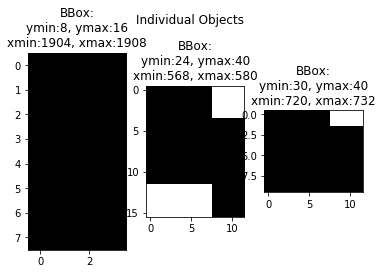

In [17]:
fig, ax = plt.subplots()
ax.imshow(isodata)
ax.set_title('Original Data')

fig, ax = plt.subplots()
ax.imshow(label_image, cmap=new_map)
ax.set_title('Labeled objects')

fig, axes = plt.subplots(ncols=3)
for ax, sli in zip(axes.flat, patches_sample):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
fig.suptitle('Individual Objects')

plt.show()

In [18]:
patch_arrs = []

for i in range(len(patches)):
    patch_arrs.append(np.interp(label_image[patches[i]], 
                                (label_image[patches[i]].min(), label_image[patches[i]].max()), 
                                (0, 1)))

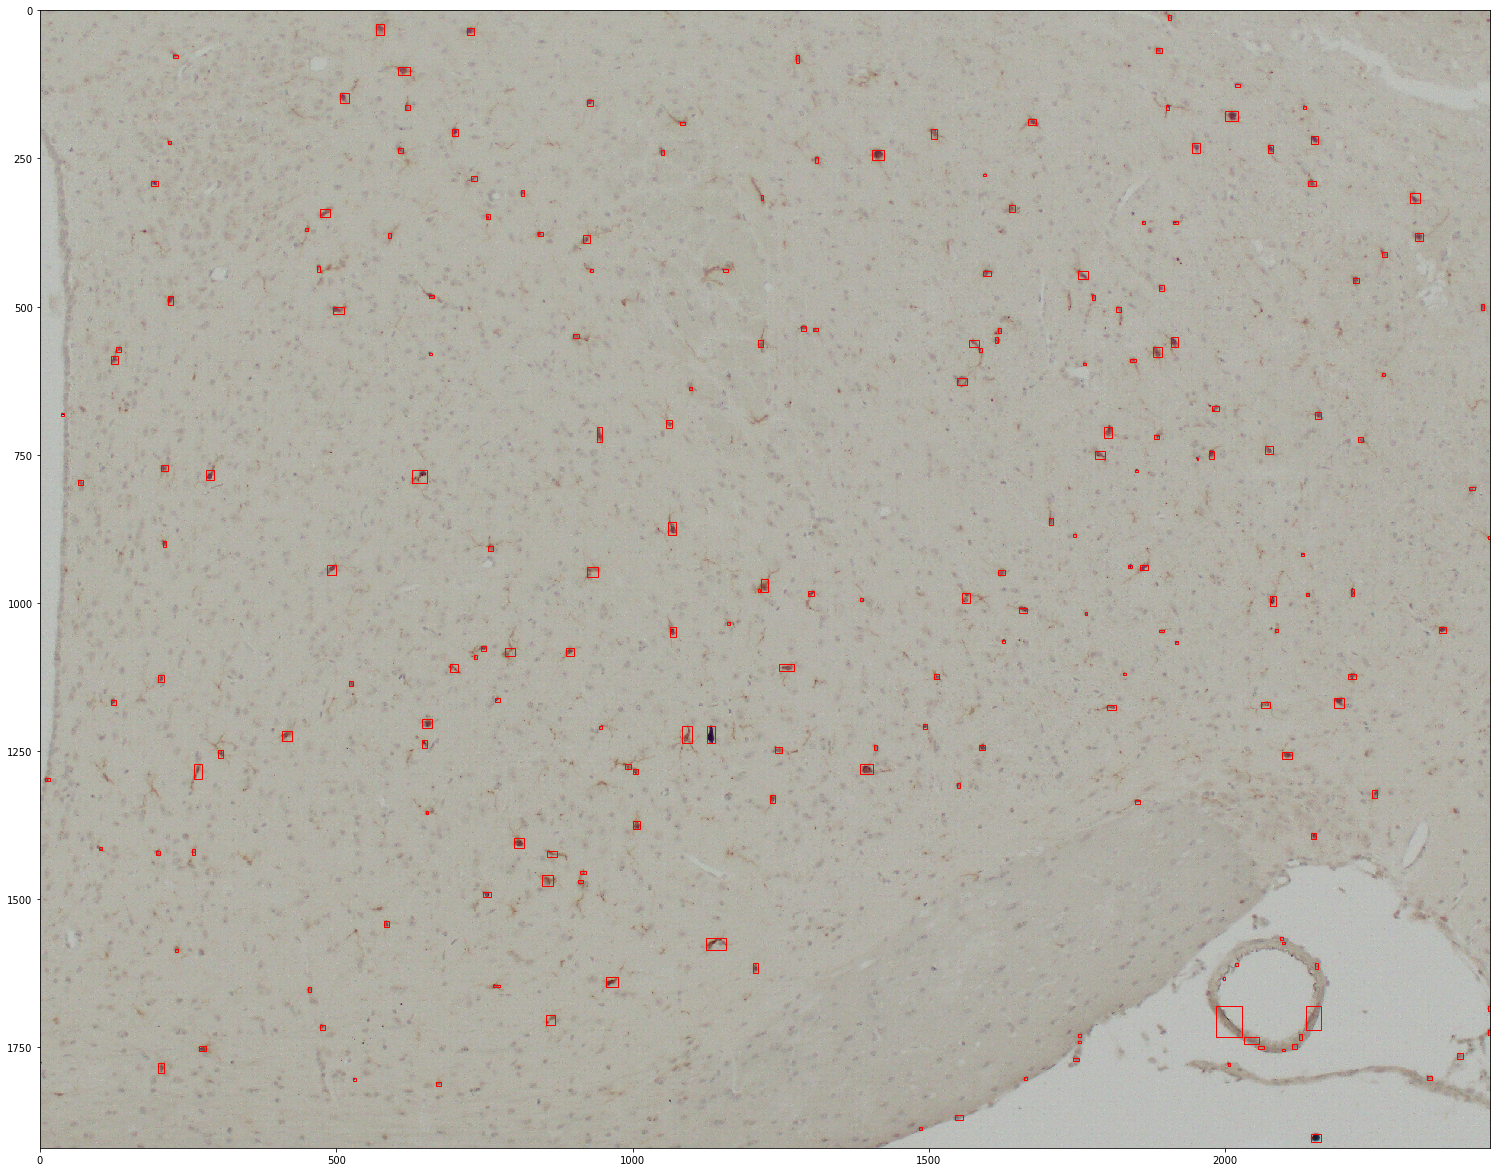

In [19]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

if __name__ == '__main__':
    fig = plt.figure(figsize=(26, 26))
    ax = fig.add_subplot(111)

    data = original
    im = ax.imshow(data)    
    data_slices = patches

    bboxes = slice_to_bbox(data_slices)
    for bbox in bboxes:
        xwidth = bbox.x2 - bbox.x1
        ywidth = bbox.y2 - bbox.y1
        p = mpatches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth,
                              fc = 'none', ec = 'red')
        ax.add_patch(p)

    plt.show()

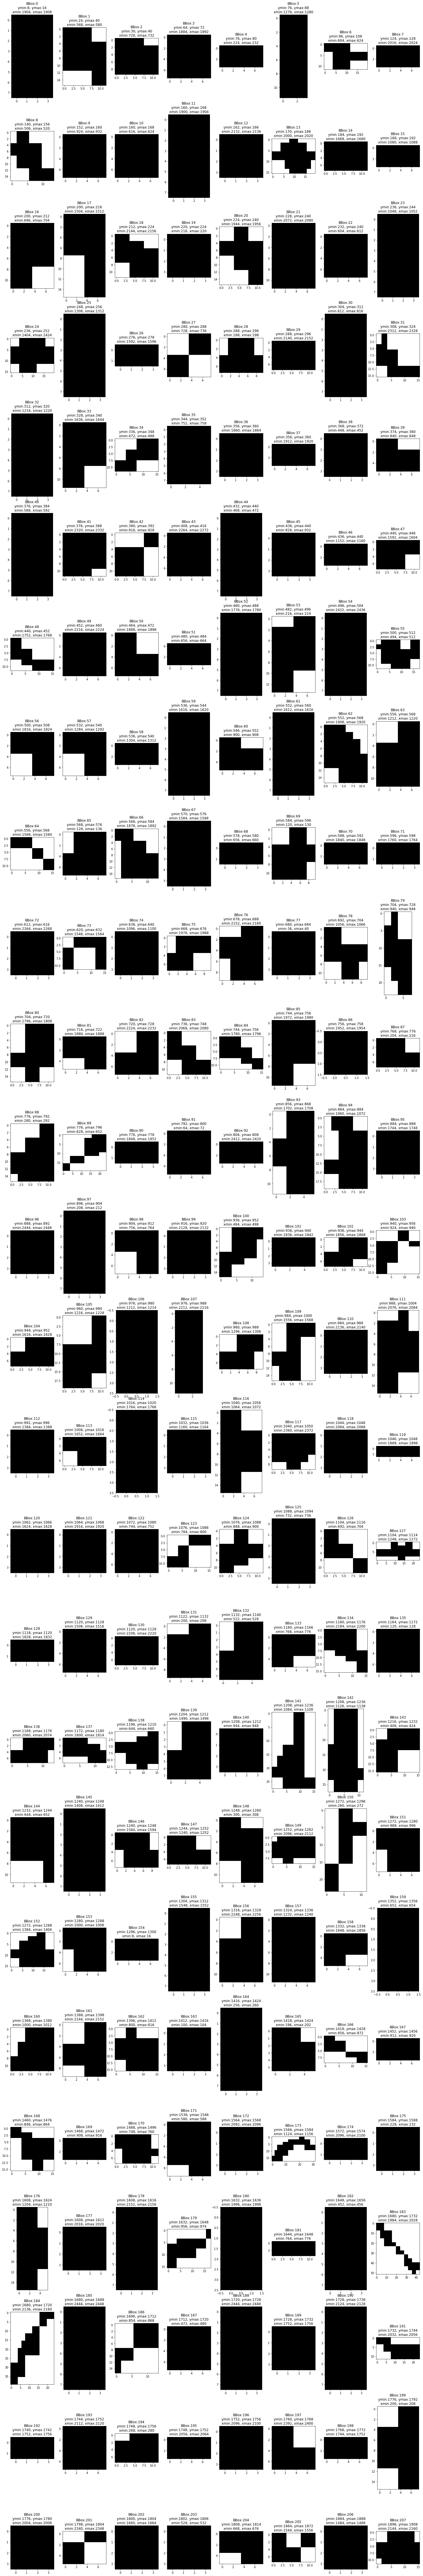

In [50]:
fig, axes = plt.subplots(ncols=8, nrows=26, figsize=(26, 168))
i=0
for ax, sli in zip(axes.flat, patches):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:' +str(i) +'\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
    i+=1

plt.show()

In [ ]:
labels = 

In [20]:
df = pd.DataFrame(columns=['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent'])

In [21]:
regions = regionprops(label_image)

for region in regions:
    region_dict = {'solidity': region.solidity,
                   'orientation': region.orientation,
                   'diameter': region.equivalent_diameter,
                   'area': region.area,
                   'eccentricity': region.eccentricity,
                   'convex area': region.convex_area,
                   'major axis length': region.major_axis_length,
                   'minor axis length': region.minor_axis_length,
                   'extent': region.extent}
    df=df.append(region_dict, ignore_index=True)
    
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1    0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2    0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3    1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4    1.000000     1.570796   6.383076   32.0      0.872872         32.0   
..        ...          ...        ...    ...           ...          ...   
203  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
204  0.952381     1.252759   7.136496   40.0      0.773218         42.0   
205  0.744186    -1.311223   9.027033   64.0      0.794225         86.0   
206  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
207  0.937143    -1.525217  14.450304  164.0      0.628268        175.0   

     major axis length  minor axis length    extent  
0             9.165151           4.472136  1.000000  
1            17.580112          11.364941  0.750000  
2            13.746256          10.763679  0.933333  
3             9.165151           9.165151  1.000000  
4             9.165151           4.472136  1.000000  
..                 ...                ...       ...  
203           4.472136           4.472136  1.000000  
204           9.300361           5.897736  0.833333  
205          14.300282           8.689185  0.666667  
206           4.472136           4.472136  1.000000  
207          16.724903          13.011931  0.854167  

[208 rows x 9 columns]

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


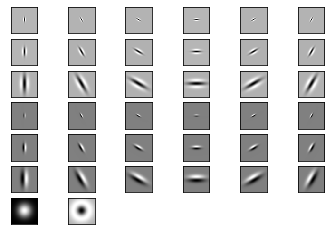

In [22]:
#https://gist.github.com/amueller/3129692
##########################################################################
# Maximum Response filterbank from
# http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
# based on several edge and bar filters.
# Adapted to Python by Andreas Mueller amueller@ais.uni-bonn.de
# Share and enjoy
#

import cv2
import pickle

from itertools import product, chain

def makeRFSfilters(radius=28, sigmas=[1, 2, 4], n_orientations=6):
    """ Generates filters for RFS filterbank.
    Parameters
    ----------
    radius : int, default 28
        radius of all filters. Size will be 2 * radius + 1
    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed
    n_orientations : int
        number of fractions the half-angle will be divided in
    Returns
    -------
    edge : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains edge filters on different scales and orientations
    bar : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains bar filters on different scales and orientations
    rot : ndarray (2, 2*radius+1, 2*radius+1)
        contains two rotation invariant filters, Gaussian and Laplacian of
        Gaussian
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = np.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= np.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        temp = gx*gy
        temp = np.reshape(temp,(gx.shape[0],1))
        #f = (gx * gy).reshape(sup, sup)
        f = np.reshape(temp,(int(sup), int(sup)))
        # normalize
        f /= np.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = np.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = np.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in range(n_orientations):
            # Not 2pi as filters have symmetry
            angle = np.pi * orient / n_orientations
            c, s = np.cos(angle), np.sin(angle)
            rotpts = np.dot(np.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))

    print (len(rot), len(bar))
    length = np.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    # reshape rot and edge
    edge = np.asarray(edge)
    edge = edge.reshape(len(sigmas), n_orientations, int(support), int(support))
    bar = np.asarray(bar).reshape(edge.shape)
    rot = np.asarray(rot)[:, np.newaxis, :, :]
    print (edge.shape, bar.shape, rot.shape)
    return edge, bar, rot


def apply_filterbank(img, filterbank):
    from scipy.ndimage import convolve
    result = []
    for battery in filterbank:
        for scale in battery:
            response = []
            for filt in scale:
                response.append(convolve(img, filt))
            max_response = np.max(response, axis=0)
            result.append(max_response)
    return result


if __name__ == "__main__":

    sigmas = [1, 2, 4]
    n_sigmas = len(sigmas)
    n_orientations = 6

    edge, bar, rot = makeRFSfilters(sigmas=sigmas,
            n_orientations=n_orientations)

    n = n_sigmas * n_orientations

    # plot filters
    # 2 is for bar / edge, + 1 for rot
    fig, ax = plt.subplots(n_sigmas * 2 + 1, n_orientations)
    for k, filters in enumerate([bar, edge]):
        for i, j in product(range(n_sigmas), range(n_orientations)):
            row = i + k * n_sigmas
            ax[row, j].imshow(filters[i, j, :, :], cmap=plt.cm.gray)
            ax[row, j].set_xticks(())
            ax[row, j].set_yticks(())
    ax[-1, 0].imshow(rot[0, 0], cmap=plt.cm.gray)
    ax[-1, 0].set_xticks(())
    ax[-1, 0].set_yticks(())
    ax[-1, 1].imshow(rot[1, 0], cmap=plt.cm.gray)
    ax[-1, 1].set_xticks(())
    ax[-1, 1].set_yticks(())
    for i in range(2, n_orientations):
        ax[-1, i].set_visible(False)

    plt.show()

In [23]:
filterbank = makeRFSfilters()
top8_arr = []

for patch in patch_arrs:
    top8_arr.append(apply_filterbank(patch, filterbank))

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


In [24]:
df_text = pd.DataFrame(columns=['edge1', 'edge2', 'edge3', 'bar1', 'bar2', 'bar3', 'gauss', 'lap'])

In [25]:
for top8 in top8_arr:
    top8_dict = {'edge1': top8[0],
                 'edge2': top8[1],
                 'edge3': top8[2],
                 'bar1': top8[3],
                 'bar2': top8[4],
                 'bar3': top8[5],
                 'gauss': top8[6],
                 'lap': top8[7]}
    df_text=df_text.append(top8_dict, ignore_index=True)
df_text.head()

edge1  \
0  [[2.9446729917223982e-08, 4.707935570833403e-0...   
1  [[0.0008403239484020726, 0.005052573072156385,...   
2  [[0.0012198142313506748, 0.00229771097272884, ...   
3  [[9.471111151162465e-18, 9.471111151162465e-18...   
4  [[9.471111151162465e-18, 9.471111151162465e-18...   

                                               edge2  \
0  [[0.0002165497541490446, 0.0001366156373560051...   
1  [[0.012140955990381659, 0.039613083879276305, ...   
2  [[0.02720603799342464, 0.02881079070630749, 0....   
3  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
4  [[5.21091876916238e-17, 5.21091876916238e-17, ...   

                                               edge3  \
0  [[0.0008710792390768863, 0.0006303978299891589...   
1  [[0.02221043464890327, 0.03447657917238227, 0....   
2  [[0.018195837447291488, 0.020969209805675005, ...   
3  [[8.046006819465604e-18, 8.046006819465604e-18...   
4  [[8.046006819465604e-18, 8.046006819465604e-18...   

                                                bar1  \
0  [[-3.461109476381679e-15, -3.461109476381679e-...   
1  [[2.1155965085150714e-05, 4.008451020246449e-0...   
2  [[0.0024407860986846706, 0.004597836473598483,...   
3  [[-3.461109476381679e-15, -3.461109476381679e-...   
4  [[-3.461109476381679e-15, -3.461109476381679e-...   

                                                bar2  \
0  [[0.0006871494652846738, 0.0004335048198364891...   
1  [[0.04180113581531957, 0.04426679031530251, 0....   
2  [[0.08781729185042429, 0.09299720953520685, 0....   
3  [[-9.540562463010898e-15, -9.540562463010898e-...   
4  [[-9.540562463010898e-15, -9.540562463010898e-...   

                                                bar3  \
0  [[0.0036295604398596877, 0.0031932971106353914...   
1  [[0.14493424404286384, 0.14488915020826199, 0....   
2  [[0.11889189577389733, 0.11886100336674699, 0....   
3  [[-4.974419322962867e-11, -4.974419322962867e-...   
4  [[-4.974419322962867e-11, -4.974419322962867e-...   

                                               gauss  \
0  [[0.9983306416218514, 0.9986028419860242, 0.99...   
1  [[0.7742353219984683, 0.7740987329241487, 0.77...   
2  [[0.9358003182786597, 0.9355816864983373, 0.93...   
3  [[0.9999999999999984, 0.9999999999999984, 0.99...   
4  [[0.9999999999999984, 0.9999999999999984, 0.99...   

                                                 lap  
0  [[0.6783723495710862, 0.6786479732097033, 0.67...  
1  [[0.45102715051654, 0.45223296526686496, 0.454...  
2  [[0.6248597869577238, 0.6261245168366327, 0.62...  
3  [[0.6820942326742343, 0.6820942326742343, 0.68...  
4  [[0.6820942326742343, 0.6820942326742343, 0.68...

In [26]:
df = df.join(df_text)
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1    0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2    0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3    1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4    1.000000     1.570796   6.383076   32.0      0.872872         32.0   
..        ...          ...        ...    ...           ...          ...   
203  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
204  0.952381     1.252759   7.136496   40.0      0.773218         42.0   
205  0.744186    -1.311223   9.027033   64.0      0.794225         86.0   
206  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
207  0.937143    -1.525217  14.450304  164.0      0.628268        175.0   

     major axis length  minor axis length    extent  \
0             9.165151           4.472136  1.000000   
1            17.580112          11.364941  0.750000   
2            13.746256          10.763679  0.933333   
3             9.165151           9.165151  1.000000   
4             9.165151           4.472136  1.000000   
..                 ...                ...       ...   
203           4.472136           4.472136  1.000000   
204           9.300361           5.897736  0.833333   
205          14.300282           8.689185  0.666667   
206           4.472136           4.472136  1.000000   
207          16.724903          13.011931  0.854167   

                                                 edge1  \
0    [[2.9446729917223982e-08, 4.707935570833403e-0...   
1    [[0.0008403239484020726, 0.005052573072156385,...   
2    [[0.0012198142313506748, 0.00229771097272884, ...   
3    [[9.471111151162465e-18, 9.471111151162465e-18...   
4    [[9.471111151162465e-18, 9.471111151162465e-18...   
..                                                 ...   
203  [[9.471111151162465e-18, 9.471111151162465e-18...   
204  [[-0.00013115696965726258, -0.0005637657878592...   
205  [[0.029825058730421235, 0.06600215027978558, 0...   
206  [[2.9446729917223982e-08, 4.707935570833403e-0...   
207  [[0.03679239087562311, 0.09748397809797567, 0....   

                                                 edge2  \
0    [[0.0002165497541490446, 0.0001366156373560051...   
1    [[0.012140955990381659, 0.039613083879276305, ...   
2    [[0.02720603799342464, 0.02881079070630749, 0....   
3    [[5.21091876916238e-17, 5.21091876916238e-17, ...   
4    [[5.21091876916238e-17, 5.21091876916238e-17, ...   
..                                                 ...   
203  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
204  [[-0.0006190984520856923, 0.013875857532872979...   
205  [[0.037242509790348315, 0.1256258317112205, 0....   
206  [[0.0005632650228842082, 0.0005618140825347063...   
207  [[0.06661253421550238, 0.13306481771774445, 0....   

                                                 edge3  \
0    [[0.0008710792390768863, 0.0006303978299891589...   
1    [[0.02221043464890327, 0.03447657917238227, 0....   
2    [[0.018195837447291488, 0.020969209805675005, ...   
3    [[8.046006819465604e-18, 8.046006819465604e-18...   
4    [[8.046006819465604e-18, 8.046006819465604e-18...   
..                                                 ...   
203  [[8.046006819465604e-18, 8.046006819465604e-18...   
204  [[0.002821191307280287, 0.0053569597049825035,...   
205  [[0.03805170843789788, 0.1095477496737967, 0.1...   
206  [[0.0077400640495346364, 0.007594252425913872,...   
207  [[0.027199992852325668, 0.04382116552749143, 0...   

                                                  bar1  \
0    [[-3.461109476381679e-15, -3.461109476381679e-...   
1    [[2.1155965085150714e-05, 4.008451020246449e-0...   
2    [[0.0024407860986846706, 0.004597836473598483,...   
3    [[-3.461109476381679e-15, -3.461109476381679e-...   
4    [[-3.461109476381679e-15, -3.461109476381679e-...   
..  

In [27]:
hog_arr = []

for patch in patch_arrs:
    hog_arr.append(hog(patch, pixels_per_cell=(4, 4), cells_per_block=(1, 1)))

df['hog'] = hog_arr
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1    0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2    0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3    1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4    1.000000     1.570796   6.383076   32.0      0.872872         32.0   
..        ...          ...        ...    ...           ...          ...   
203  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
204  0.952381     1.252759   7.136496   40.0      0.773218         42.0   
205  0.744186    -1.311223   9.027033   64.0      0.794225         86.0   
206  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
207  0.937143    -1.525217  14.450304  164.0      0.628268        175.0   

     major axis length  minor axis length    extent  \
0             9.165151           4.472136  1.000000   
1            17.580112          11.364941  0.750000   
2            13.746256          10.763679  0.933333   
3             9.165151           9.165151  1.000000   
4             9.165151           4.472136  1.000000   
..                 ...                ...       ...   
203           4.472136           4.472136  1.000000   
204           9.300361           5.897736  0.833333   
205          14.300282           8.689185  0.666667   
206           4.472136           4.472136  1.000000   
207          16.724903          13.011931  0.854167   

                                                 edge1  \
0    [[2.9446729917223982e-08, 4.707935570833403e-0...   
1    [[0.0008403239484020726, 0.005052573072156385,...   
2    [[0.0012198142313506748, 0.00229771097272884, ...   
3    [[9.471111151162465e-18, 9.471111151162465e-18...   
4    [[9.471111151162465e-18, 9.471111151162465e-18...   
..                                                 ...   
203  [[9.471111151162465e-18, 9.471111151162465e-18...   
204  [[-0.00013115696965726258, -0.0005637657878592...   
205  [[0.029825058730421235, 0.06600215027978558, 0...   
206  [[2.9446729917223982e-08, 4.707935570833403e-0...   
207  [[0.03679239087562311, 0.09748397809797567, 0....   

                                                 edge2  \
0    [[0.0002165497541490446, 0.0001366156373560051...   
1    [[0.012140955990381659, 0.039613083879276305, ...   
2    [[0.02720603799342464, 0.02881079070630749, 0....   
3    [[5.21091876916238e-17, 5.21091876916238e-17, ...   
4    [[5.21091876916238e-17, 5.21091876916238e-17, ...   
..                                                 ...   
203  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
204  [[-0.0006190984520856923, 0.013875857532872979...   
205  [[0.037242509790348315, 0.1256258317112205, 0....   
206  [[0.0005632650228842082, 0.0005618140825347063...   
207  [[0.06661253421550238, 0.13306481771774445, 0....   

                                                 edge3  \
0    [[0.0008710792390768863, 0.0006303978299891589...   
1    [[0.02221043464890327, 0.03447657917238227, 0....   
2    [[0.018195837447291488, 0.020969209805675005, ...   
3    [[8.046006819465604e-18, 8.046006819465604e-18...   
4    [[8.046006819465604e-18, 8.046006819465604e-18...   
..                                                 ...   
203  [[8.046006819465604e-18, 8.046006819465604e-18...   
204  [[0.002821191307280287, 0.0053569597049825035,...   
205  [[0.03805170843789788, 0.1095477496737967, 0.1...   
206  [[0.0077400640495346364, 0.007594252425913872,...   
207  [[0.027199992852325668, 0.04382116552749143, 0...   

                                                  bar1  \
0    [[-3.461109476381679e-15, -3.461109476381679e-...   
1    [[2.1155965085150714e-05, 4.008451020246449e-0...   
2    [[0.0024407860986846706, 0.004597836473598483,...   
3    [[-3.461109476381679e-15, -3.461109476381679e-...   
4    [[-3.461109476381679e-15, -3.461109476381679e-...   
..  

In [28]:
df['label'] = labels
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent  \
0           9.165151           4.472136  1.000000   
1          17.580112          11.364941  0.750000   
2          13.746256          10.763679  0.933333   
3           9.165151           9.165151  1.000000   
4           9.165151           4.472136  1.000000   

                                               edge1  \
0  [[2.9446729917223982e-08, 4.707935570833403e-0...   
1  [[0.0008403239484020726, 0.005052573072156385,...   
2  [[0.0012198142313506748, 0.00229771097272884, ...   
3  [[9.471111151162465e-18, 9.471111151162465e-18...   
4  [[9.471111151162465e-18, 9.471111151162465e-18...   

                                               edge2  \
0  [[0.0002165497541490446, 0.0001366156373560051...   
1  [[0.012140955990381659, 0.039613083879276305, ...   
2  [[0.02720603799342464, 0.02881079070630749, 0....   
3  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
4  [[5.21091876916238e-17, 5.21091876916238e-17, ...   

                                               edge3  \
0  [[0.0008710792390768863, 0.0006303978299891589...   
1  [[0.02221043464890327, 0.03447657917238227, 0....   
2  [[0.018195837447291488, 0.020969209805675005, ...   
3  [[8.046006819465604e-18, 8.046006819465604e-18...   
4  [[8.046006819465604e-18, 8.046006819465604e-18...   

                                                bar1  \
0  [[-3.461109476381679e-15, -3.461109476381679e-...   
1  [[2.1155965085150714e-05, 4.008451020246449e-0...   
2  [[0.0024407860986846706, 0.004597836473598483,...   
3  [[-3.461109476381679e-15, -3.461109476381679e-...   
4  [[-3.461109476381679e-15, -3.461109476381679e-...   

                                                bar2  \
0  [[0.0006871494652846738, 0.0004335048198364891...   
1  [[0.04180113581531957, 0.04426679031530251, 0....   
2  [[0.08781729185042429, 0.09299720953520685, 0....   
3  [[-9.540562463010898e-15, -9.540562463010898e-...   
4  [[-9.540562463010898e-15, -9.540562463010898e-...   

                                                bar3  \
0  [[0.0036295604398596877, 0.0031932971106353914...   
1  [[0.14493424404286384, 0.14488915020826199, 0....   
2  [[0.11889189577389733, 0.11886100336674699, 0....   
3  [[-4.974419322962867e-11, -4.974419322962867e-...   
4  [[-4.974419322962867e-11, -4.974419322962867e-...   

                                               gauss  \
0  [[0.9983306416218514, 0.9986028419860242, 0.99...   
1  [[0.7742353219984683, 0.7740987329241487, 0.77...   
2  [[0.9358003182786597, 0.9355816864983373, 0.93...   
3  [[0.9999999999999984, 0.9999999999999984, 0.99...   
4  [[0.9999999999999984, 0.9999999999999984, 0.99...   

                                                 lap  \
0  [[0.6783723495710862, 0.6786479732097033, 0.67...   
1  [[0.45102715051654, 0.45223296526686496, 0.454...   
2  [[0.6248597869577238, 0.6261245168366327, 0.62...   
3  [[0.6820942326742343, 0.6820942326742343, 0.68...   
4  [[0.6820942326742343, 0.6820942326742343, 0.68...   

                                                 hog  label  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0

In [29]:
#NORMALIZE FEATURES

In [30]:
#LABEL DATA

In [31]:
# train-test split
df_X = df.iloc[:, 0:18]
df_Y = df.iloc[:, 18]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [32]:
clf = svm.LinearSVC()

#clf.fit(X_train, y_train)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [33]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches